## Fine-tuned the MCQ-tuned model using a Custom Summarisation + QnA dataset to create this Integrated model and then converted it to GGUF format

---

# Summarisation + QnA Custom Dataset Creation

## 1. Introduction

High-quality data is fundamental for producing a good model; the higher the quality of the data, the better the resulting model. The following steps outline the process of creating a dataset specifically for fine-tuning our Llama2 model.



![](https://i.imgur.com/IDNhAWH.png)


There are several types of datasets that can be used to fine-tune Large Language Models (LLMs):

1. **Instruction Datasets:** These datasets contain direct instructions or prompts followed by the correct or expected outputs.

2. **Raw Completion:** This involves providing a prompt to the model and letting it generate a response without any predefined correct answer.

3. **Preference Datasets:** These datasets include human feedback in the form of preferences, where annotators compare pairs of model outputs to determine which is better.

4. **Human Feedback Data:** This is specific to Reinforcement Learning from Human Feedback (RLHF) and involves direct feedback on the model's outputs from human annotators.

5. **Demonstration Data:** Also used in RLHF, these datasets consist of examples showing ideal model outputs or actions, typically created by humans.

6. **Reward Modeling Data:** Used to train a reward model in RLHF, this dataset predicts human feedback on model outputs based on actual feedback data.

7. **Dialogue Data:** Particularly relevant for conversational AI, this includes annotated conversations that indicate the quality of responses or provide corrections.


---



* Typically, an instruction dataset is utilized for fine-tuning the Llama 2 Model. Since we are focusing on Supervised Fine Tuning, the instruction dataset becomes our primary choice.

Therefore, we have 2 options:

1. Create our own Instruction Dataset.
2. Modify an existing instruction dataset, which involves filtering, modifying, and enriching it.

We have decided to proceed with the 1st option: creating our own Instruction Dataset.

* This will involve prompt engineering and incorporating sanity checks to ensure quality and relevance.

## 2. Load and analyze the dataset

In [ ]:
# Install libraries
!pip install -q datasets transformers sentence_transformers faiss-gpu huggingface_hub

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


ERROR: Could not find a version that satisfies the requirement faiss-gpu (from versions: none)
ERROR: No matching distribution found for faiss-gpu


In [ ]:
# Import the required libraries
import json
import sys
import pandas as pd
from datasets import Dataset, DatasetDict, load_dataset

from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import seaborn as sns

from sentence_transformers import SentenceTransformer
import faiss
from tqdm.autonotebook import tqdm
import numpy as np

In [ ]:
# Load JSON data from a file
with open("my_data_non_MCQ.json", "r") as f:
    data = json.load(f)

# Create a Pandas DataFrame from the list of dictionaries
df = pd.DataFrame(data)

# Calculate the number of rows for each dataset split
num_rows = len(df)
train_end = int(num_rows * 0.8)  # 80% for training
test_end = train_end + int(num_rows * 0.1)  # 10% for testing

# Split the DataFrame into training, testing, and validation sets
df_train = df[:train_end]
df_test = df[train_end:test_end]
df_val = df[test_end:]  # Ensures the remainder is used for validation

# Create Datasets from the DataFrames
dataset_train = Dataset.from_pandas(df_train)
dataset_test = Dataset.from_pandas(df_test)
dataset_val = Dataset.from_pandas(df_val)

# Create a DatasetDict containing the split datasets
dataset = DatasetDict({
    'train': dataset_train,
    'test': dataset_test,
    'val': dataset_val
})

# Print the structure of the created DatasetDict
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['instruction', 'input_content', 'expected_output'],
        num_rows: 448
    })
    test: Dataset({
        features: ['instruction', 'input_content', 'expected_output'],
        num_rows: 56
    })
    val: Dataset({
        features: ['instruction', 'input_content', 'expected_output'],
        num_rows: 56
    })
})


In [ ]:
# Read as pandas DataFrame
dataset['train'].to_pandas()

instruction  \
0         Summarize the concept and applications of AI   
1    Summarize the concept and applications of Mach...   
2    Summarize the concept and applications of Deep...   
3    Summarize the differences between AI, Machine ...   
4    Summarize the concept and structure of artific...   
..                                                 ...   
443  Summarize the considerations when deciding to ...   
444          Summarize the concept of Machine Learning   
445     Summarize the applications of Machine Learning   
446  Summarize the concept of Image Recognition in ...   
447  Summarize the concept of Natural Language Proc...   

                                         input_content  \
0    AI refers to the development of computer syste...   
1    Machine Learning is a subset of AI that focuse...   
2    Deep Learning is a subset of Machine Learning ...   
3                                                        
4    Artificial neural networks are built on the pr...   
..                                                 ...   
443  When considering whether to use deep learning ...   
444  Machine Learning is a subset of Artificial Int...   
445  Machine Learning has various applications acro...   
446  Image recognition is one of the applications o...   
447  Natural Language Processing (NLP) is another a...   

                                       expected_output  
0    AI, or artificial intelligence, involves the c...  
1    Machine Learning is a branch of AI that enable...  
2    Deep Learning, a subset of Machine Learning, e...  
3    AI, Machine Learning, and Deep Learning are in...  
4    Artificial neural networks are structured base...  
..                                                 ...  
443  Considerations when deciding to use deep learn...  
444  Machine Learning is a branch of AI that utiliz...  
445  Machine Learning finds applications in image r...  
446  In Machine Learning, image recognition is the ...  
447  Natural Language Processing (NLP) in Machine L...  

[448 rows x 3 columns]

In [ ]:
# Read as pandas DataFrame
dataset['test'].to_pandas()

instruction  \
0   Summarize the hyperparameters in Support Vecto...   
1            Summarize the hyperparameters in XGBoost   
2   Summarize other examples of model hyperparameters   
3   Summarize the importance of hyperparameter tun...   
4   Summarize the concept and applications of Deep...   
5   Explain the use of Deep Learning in image and ...   
6   Describe the applications of Deep Learning in ...   
7   Explain the role of Deep Learning in fraud det...   
8   Summarize the concept of artificial neural net...   
9   Summarize the architecture of artificial neura...   
10  Differentiate between machine learning and dee...   
11  Highlight the differences between machine lear...   
12             Summarize the concept of Deep Learning   
13  Explain the architecture of an artificial neur...   
14          Discuss the applications of Deep Learning   
15  Explain the different types of machine learnin...   
16  Summarize the types of neural networks used in...   
17  Summarize the applications of deep learning in...   
18  Summarize the applications of deep learning in...   
19  Summarize the applications of deep learning in...   
20   Summarize the concept of Artificial Intelligence   
21          Summarize the concept of Machine Learning   
22             Summarize the concept of Deep Learning   
23  Summarize the differences between Artificial I...   
24       Summarize the concept and applications of AI   
25  Summarize the concept and applications of Mach...   
26  Summarize the concept and applications of Deep...   
27   Summarize the common examples of AI applications   
28  Summarize the role and responsibilities of an ...   
29  Summarize the role and responsibilities of a M...   
30  Summarize the role and responsibilities of a D...   
31  Differentiate between the roles of an AI Engin...   
32  Summarize the concept of Artificial Neural Net...   
33  Summarize the concept of Biological Neural Net...   
34  Highlight the differences between Artificial N...   
35  Summarize the overall differences between Arti...   
36  Summarize the concept of hyperparameter tuning...   
37  Summarize the different types of hyperparamete...   
38  Explain the impact of learning rate and epochs...   
39  Describe the role of architecture and activati...   
40     Summarize the concept of Hyperparameter Tuning   
41  Explain the advantages and disadvantages of Hy...   
42    Discuss the challenges in Hyperparameter Tuning   
43  Describe the applications of Hyperparameter Tu...   
44          Summarize the challenges in Deep Learning   
45          Summarize the advantages of Deep Learning   
46       Summarize the disadvantages of Deep Learning   
47  Summarize the considerations when deciding to ...   
48          Summarize the concept of Machine Learning   
49  Summarize the applications of Machine Learning...   
50  Summarize the applications of Machine Learning...   
51  Summarize the applications of Machine Learning...   
52  Summarize the hyperparameters in Support Vecto...   
53           Summarize the hyperparameters in XGBoost   
54   Summarize some examples of model hyperparameters   
55  Summarize the importance of hyperparameter tun...   

                                        input_content  \
0   We take into account some essential hyperparam...   
1   The following essential XGBoost hyperparameter...   
2   Some other examples of model hyperparameters i...   
3   Hyperparameter tuning is crucial in machine le...   
4   Deep Learning is a type of Machine Learning th...   
5   Deep learning algorithms are used in image and...   
6   Deep Learning algorithms are used for tasks su...   
7   Deep Learning algorithms are used in financial...   
8   Artificial neural networks are built on the pr...   
9   Artificial neural networks have input layers, ...   
10  Machine learning and deep learning are subsets...   
11  Machine learning involves manual extraction of...   
12  Deep learning is a branch of machine learning .

In [ ]:
# Read as pandas DataFrame
dataset['val'].to_pandas()

instruction  \
0   Summarize the concept and applications of Deep...   
1   Explain the use of Deep Learning in image and ...   
2   Describe the applications of Deep Learning in ...   
3   Explain the role of Deep Learning in fraud det...   
4   Summarize the concept of artificial neural net...   
5   Explain the structure of an artificial neural ...   
6   Differentiate between Machine Learning and Dee...   
7   Discuss the differences between Machine Learni...   
8              Summarize the concept of Deep Learning   
9   Explain the architecture and functioning of ar...   
10          Discuss the applications of Deep Learning   
11  Describe the different types of machine learni...   
12  Summarize the types of neural networks in deep...   
13  Summarize the applications of deep learning in...   
14  Summarize the applications of deep learning in...   
15  Summarize the applications of deep learning in...   
16   Summarize the concept of Artificial Intelligence   
17          Summarize the concept of Machine Learning   
18             Summarize the concept of Deep Learning   
19  Summarize the differences between Artificial I...   
20  Summarize the concept of Artificial Intelligen...   
21          Summarize the concept of Machine Learning   
22             Summarize the concept of Deep Learning   
23  Summarize the applications of AI, Machine Lear...   
24  Summarize the role and responsibilities of an ...   
25  Summarize the role and responsibilities of a M...   
26  Summarize the role and responsibilities of a D...   
27  Differentiate between the roles of AI Engineer...   
28  Summarize the concept of Artificial Neural Net...   
29  Summarize the concept of Biological Neural Net...   
30  Explain the differences between Artificial Neu...   
31  Summarize the differences in parameters, compu...   
32     Summarize the concept of hyperparameter tuning   
33  Summarize the importance of hyperparameters in...   
34  Summarize the different types of hyperparamete...   
35  Summarize the impact of different hyperparamet...   
36     Summarize the concept of Hyperparameter Tuning   
37              Explain the drawbacks of GridSearchCV   
38      Describe the advantages of RandomizedSearchCV   
39  Explain the concept of Bayesian Optimization i...   
40          Summarize the challenges in deep learning   
41          Summarize the advantages of deep learning   
42       Summarize the disadvantages of deep learning   
43  Summarize the key considerations when deciding...   
44          Summarize the concept of Machine Learning   
45  Summarize the applications of Machine Learning...   
46  Summarize the applications of Machine Learning...   
47  Summarize the applications of Machine Learning...   
48  Summarize the hyperparameters in Support Vecto...   
49           Summarize the hyperparameters in XGBoost   
50          Provide examples of model hyperparameters   
51  Summarize the importance of hyperparameter tuning   
52             Summarize the concept of Deep Learning   
53  Summarize the applications of Deep Learning in...   
54  Summarize the applications of Deep Learning in...   
55  Summarize the applications of Deep Learning in...   

                                        input_content  \
0   Deep Learning is a type of Machine Learning th...   
1   Deep learning algorithms are used in image and...   
2   Deep Learning algorithms are used for tasks su...   
3   Deep Learning algorithms are used in financial...   
4   Artificial neural networks are built on the pr...   
5   An artificial neural network is composed of ar...   
6   Machine Learning and Deep Learning are both su...   
7   Machine Learning and Deep Learning have differ...   
8   Deep learning is a branch of machine learning ...   
9   Artificial neural networks (ANNs) are the buil...   
10  Deep learning has achieved significant success...   
11  Deep learning incorporates various machine lea...   
12  Deep learning models are able to automatically.

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

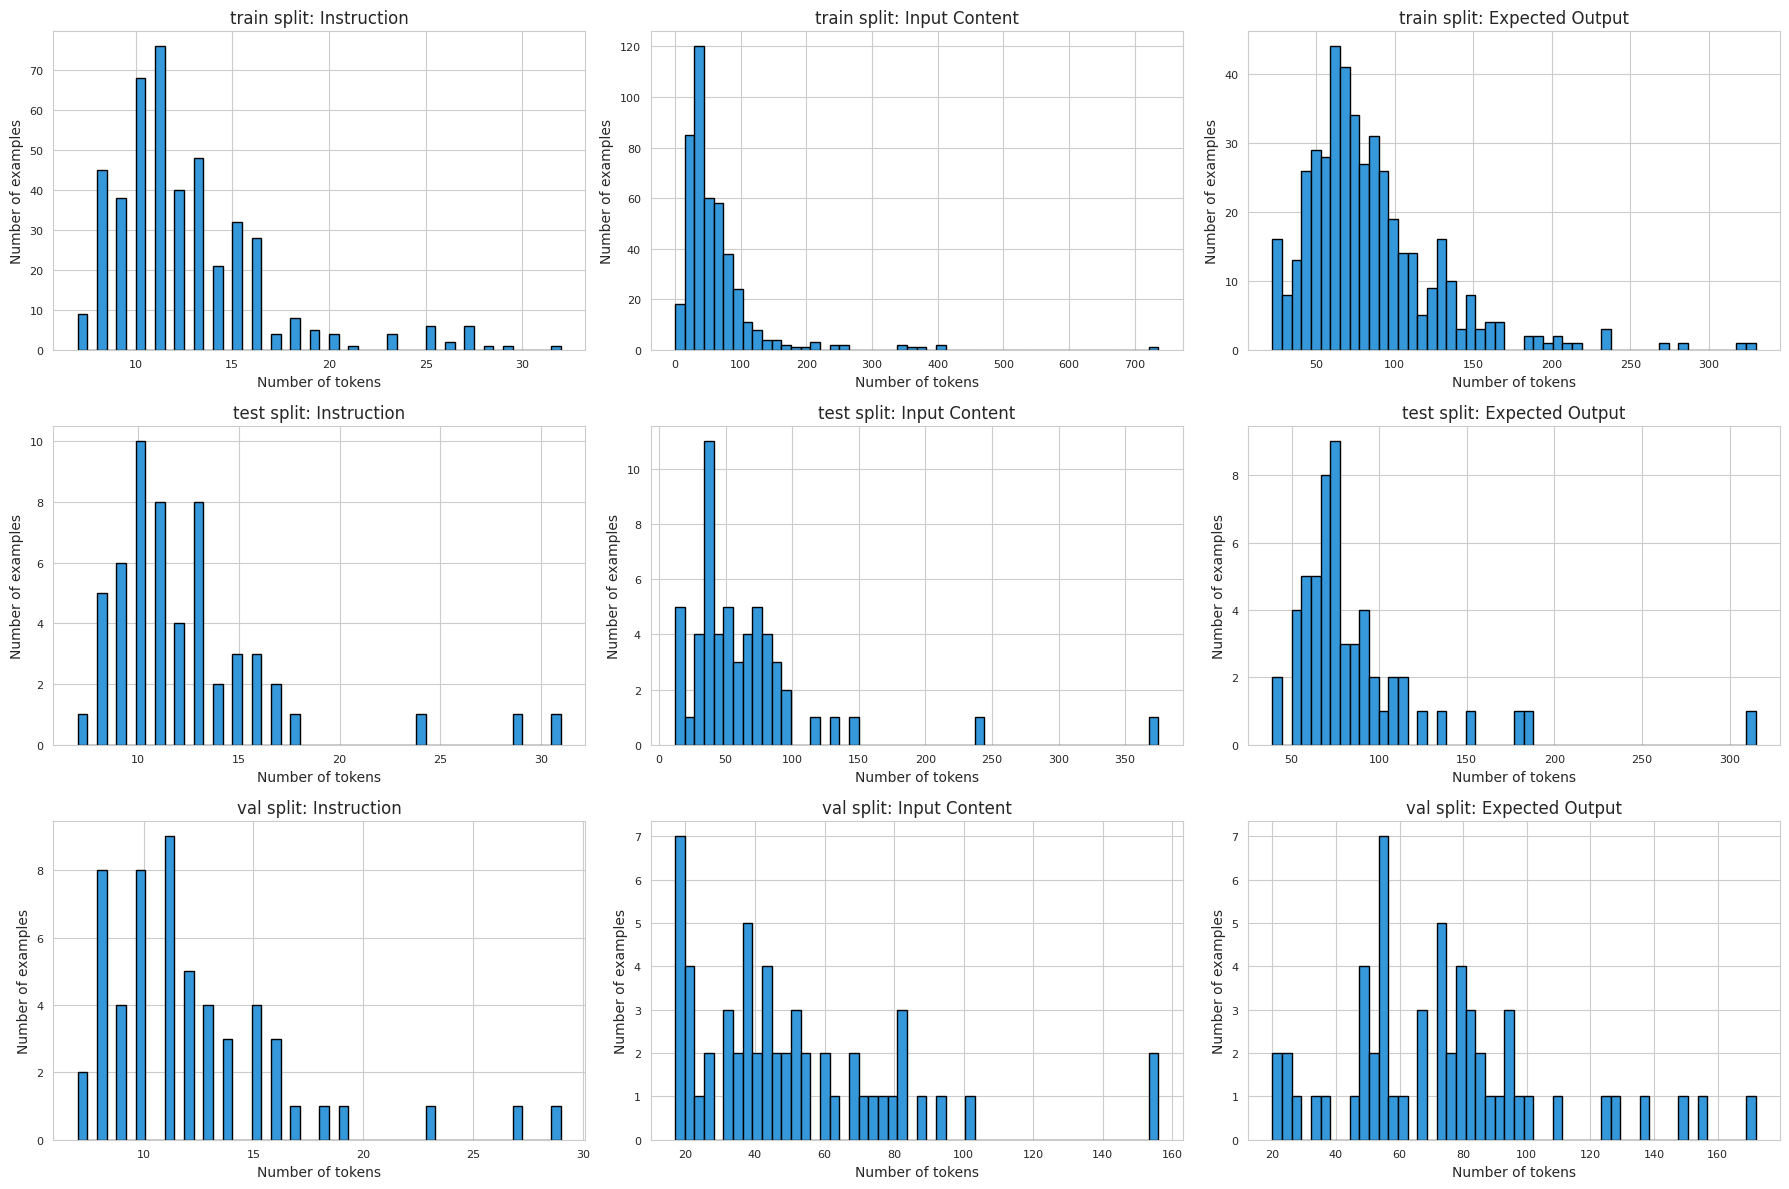

In [ ]:
# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-chat-hf")


# Function to tokenize and calculate token counts
def tokenize_and_count(dataset_split):
    # Adjust field names based on your dataset structure
    instruction_token_counts = [len(tokenizer.tokenize(example["instruction"])) for example in dataset_split]
    input_content_token_counts = [len(tokenizer.tokenize(example["input_content"])) for example in dataset_split]
    expected_output_token_counts = [len(tokenizer.tokenize(example["expected_output"])) for example in dataset_split]

    # If you need combined token counts of specific fields, adjust as necessary:
    combined_token_counts = [instruction + input_content + expected_output for instruction, input_content, expected_output in zip(instruction_token_counts, input_content_token_counts, expected_output_token_counts)]

    return instruction_token_counts, input_content_token_counts, expected_output_token_counts, combined_token_counts

# Adjust the plot_distribution function to accept a subplot axis
def plot_distribution(token_counts, title, ax):
    sns.set_style("whitegrid")
    ax.hist(token_counts, bins=50, color='#3498db', edgecolor='black')
    ax.set_title(title, fontsize=12)
    ax.set_xlabel("Number of tokens", fontsize=10)
    ax.set_ylabel("Number of examples", fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=8)

# Assuming you have a matplotlib figure `fig` and axes `axs`
fig, axs = plt.subplots(3, 3, figsize=(18, 12))  # Adjust the figure size as necessary

# Iterate over each dataset split and plot
split_names = ['train', 'test', 'val']
for i, split_name in enumerate(split_names):
    # Unpack the token counts from your dataset
    instruction_counts, input_content_counts, expected_output_counts, combined_counts = tokenize_and_count(dataset[split_name])

    # Plotting the distributions on the specified subplot axis
    plot_distribution(instruction_counts, f"{split_name} split: Instruction", axs[i, 0])  # Changed for 3x3 grid structure
    plot_distribution(input_content_counts, f"{split_name} split: Input Content", axs[i, 1])  # Changed for 3x3 grid structure
    plot_distribution(expected_output_counts, f"{split_name} split: Expected Output", axs[i, 2])  # Changed for 3x3 grid structure
    # Note: Combined is not plotted due to 3x3 grid, adjust if needed

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


## 3. Filter out rows with more than 2048 tokens

We will remove samples with more than 2048 tokens (max context size of Llama 2 by default = 4096).

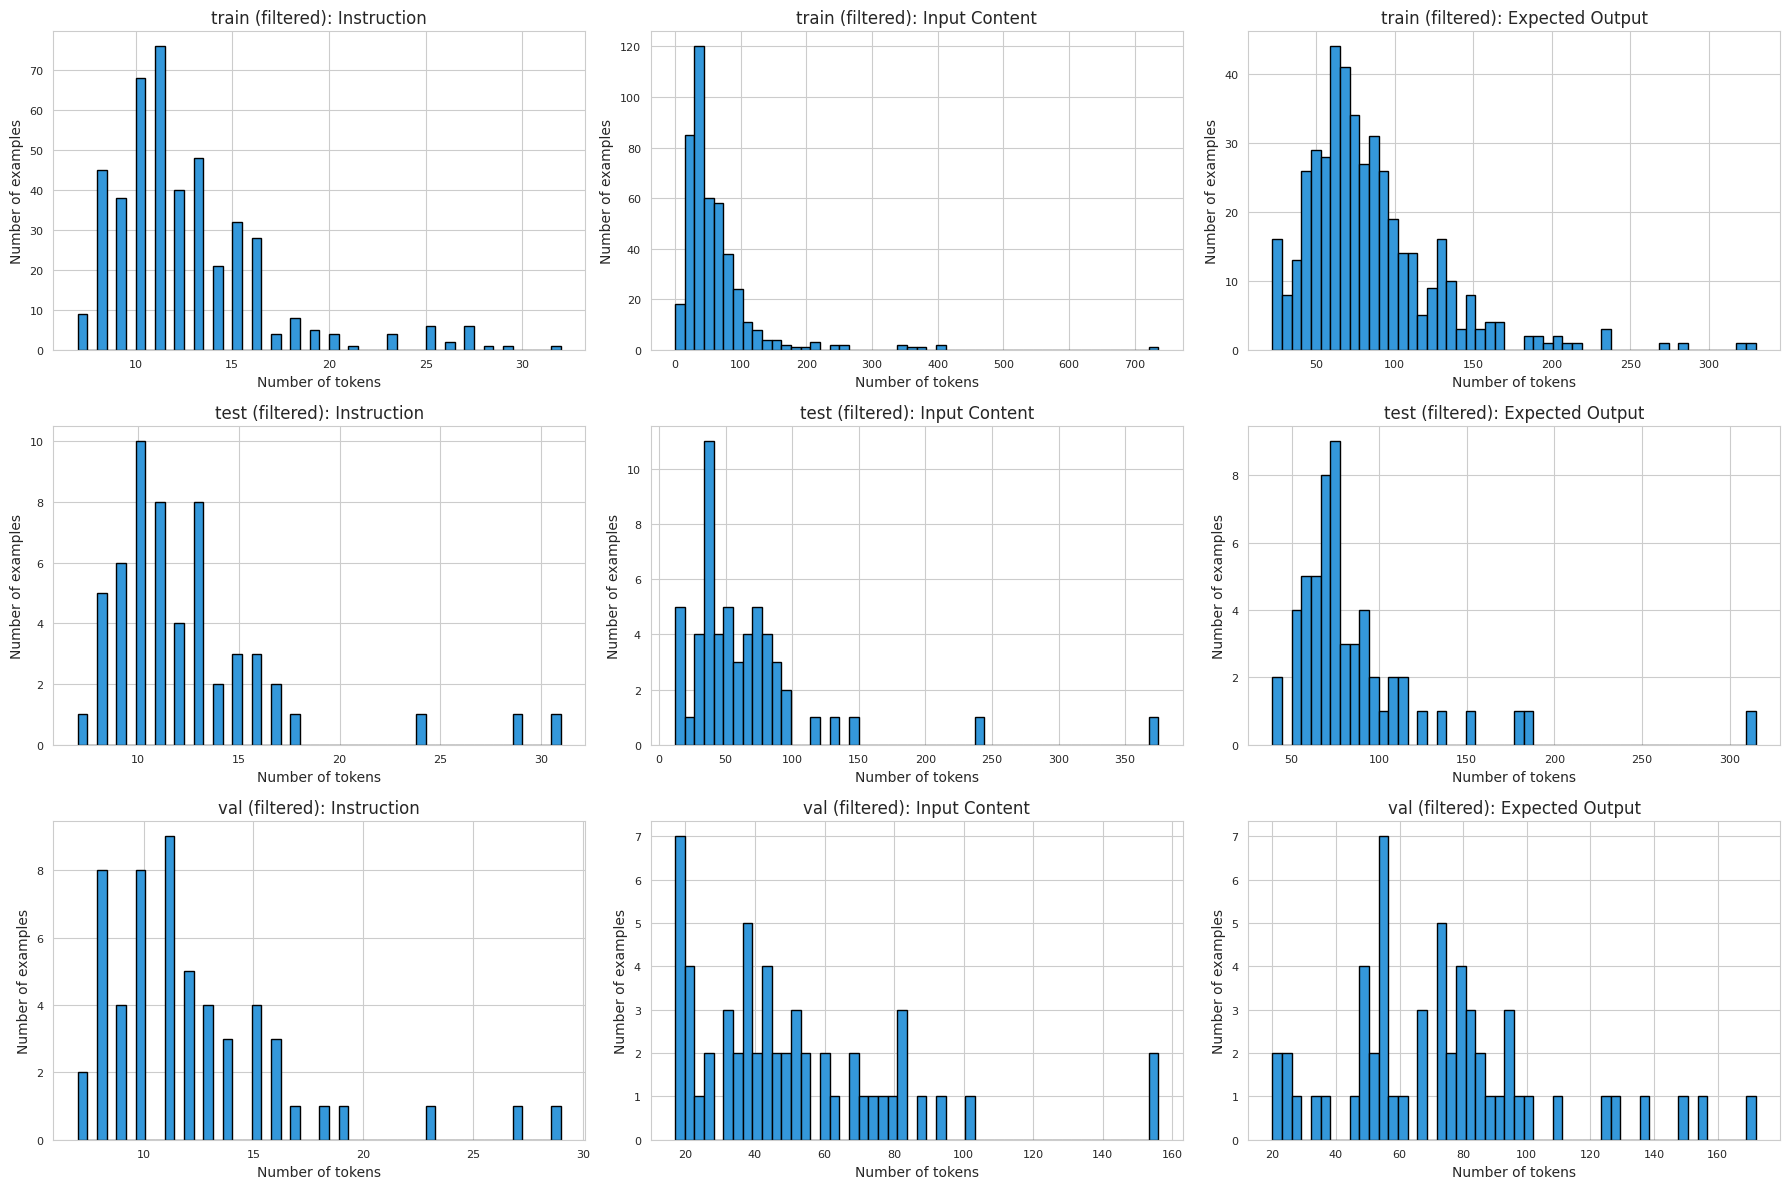

In [ ]:
# Function to filter dataset based on combined token counts
def filter_by_token_count(dataset_split, combined_token_counts, max_tokens=2048):
    filtered_dataset = [example for example, count in zip(dataset_split, combined_token_counts) if count <= max_tokens]
    return filtered_dataset

# Function to plot token distribution
def plot_distribution(token_counts, title, ax):
    sns.set_style("whitegrid")
    ax.hist(token_counts, bins=50, color='#3498db', edgecolor='black')
    ax.set_title(title, fontsize=12)
    ax.set_xlabel("Number of tokens", fontsize=10)
    ax.set_ylabel("Number of examples", fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=8)


# Set up the figure for plotting
fig, axs = plt.subplots(3, 3, figsize=(18, 12))  # 3 splits, 3 metrics (instruction, input_content, expected_output)

# Process each dataset split
for i, split_name in enumerate(['train', 'test', 'val']):
    # Tokenize and count
    instruction_counts, input_content_counts, expected_output_counts, combined_counts = tokenize_and_count(dataset[split_name])

    # Filter dataset based on combined token count
    filtered_dataset = filter_by_token_count(dataset[split_name], combined_counts)

    # Re-tokenize and count for the filtered dataset
    filtered_instruction_counts, filtered_input_content_counts, filtered_expected_output_counts, _ = tokenize_and_count(filtered_dataset)

    # Plotting the distributions for the filtered datasets
    plot_distribution(filtered_instruction_counts, f"{split_name} (filtered): Instruction", axs[i, 0])
    plot_distribution(filtered_input_content_counts, f"{split_name} (filtered): Input Content", axs[i, 1])
    plot_distribution(filtered_expected_output_counts, f"{split_name} (filtered): Expected Output", axs[i, 2])

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


Number of valid rows in train: 448
Removing 0 rows from train...
Number of valid rows in test: 56
Removing 0 rows from test...
Number of valid rows in val: 56
Removing 0 rows from val...


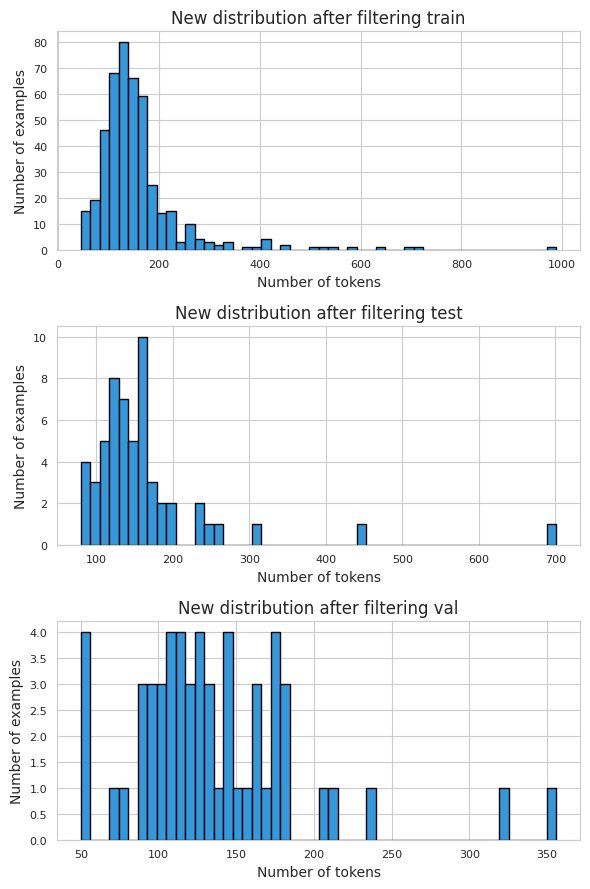

In [ ]:
def filter_and_plot(dataset_split_name, dataset_split_data, combined_token_counts, ax):
    # Filter out rows with more than 2048 tokens
    valid_indices = [i for i, count in enumerate(combined_token_counts) if count <= 2048]
    print(f"Number of valid rows in {dataset_split_name}: {len(valid_indices)}")
    print(f"Removing {len(dataset_split_data) - len(valid_indices)} rows from {dataset_split_name}...")

    # Extract valid rows based on indices
    valid_dataset = [dataset_split_data[i] for i in valid_indices]

    # Re-calculate token counts for the valid dataset
    filtered_instruction_counts, filtered_input_content_counts, filtered_expected_output_counts, valid_combined_counts = tokenize_and_count(valid_dataset)

    # Plot the new distribution for valid rows
    plot_distribution(valid_combined_counts, f"New distribution after filtering {dataset_split_name}", ax)



# Create a figure with subplots
fig, axs = plt.subplots(3, 1, figsize=(6, 9))  # Adjust figsize as necessary

# Assuming the 'dataset' variable is a dictionary containing data splits 'train', 'test', and 'val'
for i, split_name in enumerate(['train', 'test', 'val']):
    # Tokenize and count for the specific dataset split
    instruction_counts, input_content_counts, expected_output_counts, combined_counts = tokenize_and_count(dataset[split_name])

    # Filter datasets based on token count and plot the new distribution
    filter_and_plot(split_name, dataset[split_name], combined_counts, axs[i])

plt.tight_layout()
plt.show()

In [ ]:
# Initialize a flag to indicate whether any entries were removed in any split
entries_removed = False

# Iterate over each split in the dataset
for split_name in ['train', 'test', 'val']:
    # Get the original length of the split
    original_length = len(dataset[split_name])

    # Tokenize and count tokens in the split
    _, _, _, combined_counts = tokenize_and_count(dataset[split_name])  # Corrected to unpack four values

    # Determine valid indices (entries with <= 2048 tokens)
    valid_indices = [i for i, count in enumerate(combined_counts) if count <= 2048]

    # Check if any entries were removed
    if len(valid_indices) < original_length:
        entries_removed = True

        # Update the dataset split with filtered entries
        # Note: This assumes dataset[split_name] is compatible with .select() method (Hugging Face datasets)
        dataset[split_name] = dataset[split_name].select(valid_indices)

# Flag to control execution of subsequent code
continue_execution = entries_removed  # Simplified logic

if continue_execution:
    # Save the filtered dataset to disk
    dataset.save_to_disk('new_sum_qna_data')
    print("Dataset saved successfully.")
else:
    print("No entries removed due to token count. Skipping saving.")


No entries removed due to token count. Skipping saving.


---

## 4. Near-deduplication Using Embeddings

* Near-deduplication with embeddings is a technique that employs vector representations to effectively identify and manage nearly identical data entries.

* By transforming data into these vectors (embeddings), we can quantitatively measure how similar different pieces of data are. This transformation significantly improves our ability to manage large datasets, where sorting through and removing near-duplicates manually would be impractical.

* Widely used in fields like database management, information retrieval, and machine learning, this approach is crucial for efficient data handling and analysis.

---

### We Will Not Perform Deduplication on Our Summarisation + Questions & Answers Dataset.

* **Intentional Repetition for Emphasis**: In educational contexts, certain concepts may be intentionally repeated to underscore their significance. Deduplication could diminish the dataset's educational effectiveness by removing these purposeful repetitions.

* **Variations of Similar Questions**: Dataset often feature questions that, while seemingly similar, include minor variations in wording, options, or context. Inadequately designed deduplication algorithms risk eliminating these nuances, thereby losing valuable elements of the dataset.

* **Difficulty in Defining "Duplicates"**: Identifying duplicates within the dataset poses a significant challenge, as questions that appear identical might differ in subtle yet crucial ways. These distinctions often represent unique learning opportunities that would be lost through deduplication.

---


## 5. Top-k sampling

Only keep the top k samples with the most tokens.

---

### Decision on "Top-k Sampling" for Our Dataset


We have decided against employing "Top-k sampling" to select only the top k samples with the most tokens in our dataset. This approach does not align with the core objectives of dataset development for several critical reasons:


**Practical Considerations**

* Favoring question length over substance could detract from the dataset's quality, as longer questions do not necessarily equate to higher educational value. Succinct yet profound questions are typically the most beneficial and stimulating for learners.

* Given these considerations, we conclude that "Top-k sampling," which prioritizes token count, falls short of fulfilling the requirements of our dataset. The true merit of a valuable dataset resides in its diverse and balanced assortment of topics and difficulty levels, not merely in question length. This philosophy ensures our dataset remains versatile and effective across various educational and machine learning applications.
---

In [ ]:
# @title
# Push to Hugging Face Hub
dataset.push_to_hub("ssoh/sum_n_qna_dataset")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/ssoh/sum_n_qna_dataset/commit/8f46f92190bcd1be846e61fb97f6dec9c4296879', commit_message='Upload dataset', commit_description='', oid='8f46f92190bcd1be846e61fb97f6dec9c4296879', pr_url=None, pr_revision=None, pr_num=None)

---

# Fine-Tuning the Llama 2 Model

Our approach employs Supervised Fine-Tuning (SFT) to optimize the Llama 2 model. Key details of this process include:

- **Supervised Fine-Tuning (SFT)**: This method involves training the model on a curated dataset comprising specific instructions paired with corresponding responses. The primary objective is to fine-tune the model's parameters, effectively reducing the discrepancy between its generated answers and the provided ground-truth responses. These ground-truth responses serve as labels, guiding the model towards more accurate and contextually appropriate outputs.


In [ ]:
# Install necessary libraries for the project: transformers, datasets, accelerate, peft, trl, bitsandbytes, wandb and optuna
!pip install -q -U transformers datasets accelerate peft trl bitsandbytes optuna wandb

In [ ]:
# Operating System and Core Machine Learning Libraries
import os
import torch, transformers


# Dataset Handling
from datasets import load_dataset

# Transformer Models and Tokenization
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,    # Configuration class for BitsAndBytes optimization
    TrainingArguments,     # Class for setting up training hyperparameters
    pipeline,               # Utility for easy model inference deployment
    EarlyStoppingCallback,
    Trainer
)

# Advanced Fine-Tuning and Optimization Techniques
from peft import get_peft_model, LoraConfig, PeftModel, prepare_model_for_kbit_training  # Classes for Parameter-efficient Fine-tuning (PEFT)
from trl import SFTTrainer  # Trainer class for Supervised Fine-Tuning (SFT) within Text Reinforcement Learning (TRL) framework

from datasets import DatasetDict

import optuna

import shutil

import warnings

# Filter out the specific warning
warnings.filterwarnings("ignore", category=UserWarning, module="torch.utils.checkpoint")

from datetime import datetime

import wandb


2024-02-19 17:04:21.290747: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-19 17:04:21.330596: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
# Import the notebook_login function for Hugging Face Hub authentication
from huggingface_hub import notebook_login

# Execute the function to log in to Hugging Face Hub within the notebook environment
notebook_login()

## Fine-tuning Llama 2 model

We have three options when it comes to supervised fine-tuning: full fine-tuning, LoRA, and QLoRA.

![](https://i.imgur.com/7pu5zUe.png)


* In this section, we will fine-tune a Llama 2 model, which has 7 billion parameters, on a T4 GPU using Google Colab.

* Note that a T4 GPU comes with only 16 GB of VRAM, which is just enough to store the weights of Llama 2-7b (7 billion parameters × 2 bytes per parameter = 14 GB, in FP16 format).

* Additionally, we must account for the memory overhead caused by optimizer states, gradients, and forward activations.

* To significantly reduce VRAM usage, we will fine-tune the model using 4-bit precision. This is the primary reason for choosing QLoRA in our approach.

In [ ]:
# Setup for model: Define base and new model names
base_model = "ssoh/llama-2-7b-mcq_2"
new_model = "llama-2-7b-combined_datasets"


# Load the datasets from Hugging Face's datasets library
train_dataset = load_dataset("ssoh/sum_n_qna_dataset", split="train")
# test_dataset = load_dataset("ssoh/mcq_dataset", split="test")
val_dataset = load_dataset("ssoh/sum_n_qna_dataset", split="val")


# # Initialize the tokenizer for the base model and set up padding configurations
# tokenizer = AutoTokenizer.from_pretrained(base_model, use_fast=True)
# tokenizer.pad_token = tokenizer.unk_token  # Use unknown token as padding token
# tokenizer.padding_side = "right"  # Set padding to the right side of sequences

tokenizer = transformers.AutoTokenizer.from_pretrained(base_model,
                                                       padding_side='right',
                                                       add_eos_token=True)
tokenizer.pad_token = tokenizer.eos_token


Generating train split:   0%|          | 0/448 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/56 [00:00<?, ? examples/s]

Generating val split:   0%|          | 0/56 [00:00<?, ? examples/s]

In [ ]:
# Quantization configuration
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
)

# LoRA configuration
peft_config = LoraConfig(
    r=4,
    lora_alpha=8,
    lora_dropout=0.15,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=['up_proj', 'down_proj', 'gate_proj', 'k_proj', 'q_proj', 'v_proj', 'o_proj']
)

# Load base moodel
model = AutoModelForCausalLM.from_pretrained(
    base_model,
    quantization_config=bnb_config,
    device_map={"": 0}
)

# Cast the layernorm in fp32, make output embedding layer require grads, add the upcasting of the lmhead to fp32
model = prepare_model_for_kbit_training(model)

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/3.59G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
print(model)


LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear4bit(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): Lla

In [ ]:
# Initialize WandB
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: szehanz. Use `wandb login --relogin` to force relogin


True

In [ ]:
def objective(trial):

    # Define hyperparameters outside the wandb.init to use them later in the code
    learning_rate = trial.suggest_float('learning_rate', 2e-4, 5e-4, log=True)
    num_train_epochs = trial.suggest_categorical('num_train_epochs', [4, 6, 8])
    per_device_train_batch_size = trial.suggest_categorical('per_device_train_batch_size', [16, 32])
    warmup_steps = trial.suggest_int('warmup_steps', 3, 5)

    wandb.init(
        project="Education-Chatbot-Optimization",
        entity="szehanz",
        group="optuna-optimization",
        job_type="hyperparameter_search",
        reinit=True,
        config={
            "learning_rate": learning_rate,
            "num_train_epochs": num_train_epochs,
            "per_device_train_batch_size": per_device_train_batch_size,
            "warmup_steps": warmup_steps
        }
    )

    # Format the current date and time
    current_time = datetime.now().strftime("%Y%m%d-%H%M%S")
    output_dir = f"train_out_dir_{current_time}"                  # Append the current date and time to the directory name

    # Create the output directory
    os.makedirs(output_dir, exist_ok=True)                        # Using exist_ok=True to avoid error if the directory already exists


    # Define TrainingArguments with the suggested hyperparameters
    training_args = TrainingArguments(
        output_dir=output_dir,                                    # Directory for saving output models and checkpoints.
        save_strategy="steps",                                    # Save model checkpoints at regular step intervals.
        save_steps=10,                                            # Save model checkpoints every 10 steps.
        learning_rate=learning_rate,                              # Initial learning rate for the optimizer.
        per_device_train_batch_size=per_device_train_batch_size,  # Batch size per device during training.
        per_device_eval_batch_size=8,                             # Batch size per device during evaluation.
        num_train_epochs=num_train_epochs,                        # Total number of training epochs.
        warmup_steps=warmup_steps,                                # Number of warmup steps for the learning rate scheduler.
        evaluation_strategy='steps',                              # Perform evaluation at regular step intervals.
        eval_steps=10,                                            # Perform evaluation every 10 steps.
        logging_steps=10,
        optim='paged_adamw_8bit',                                 # Specifies the optimizer to use.
        lr_scheduler_type='linear',                               # Type of learning rate scheduler.
        gradient_accumulation_steps=1,                            # Number of steps to accumulate gradients before performing an update.
        load_best_model_at_end=True,                              # Load the best model based on evaluation metric at the end of training.
        report_to='wandb',                                         # Disable automatic integrations with external reporting tools.
    )


    # Initialize the Trainer with early stopping callback inside the objective function
    trainer = SFTTrainer(
        model=model,                                              # Ensure a function or a mechanism to initialize your model
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        peft_config=peft_config,
        dataset_text_field="instruction",
        tokenizer=tokenizer,
        args=training_args,
        max_seq_length=4096,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
    )

    # Train the model and evaluate within the objective function
    trainer.train()
    eval_result = trainer.evaluate()

    # Log the primary metric to WandB
    wandb.log({"eval_loss": eval_result["eval_loss"]})

    # Finish the WandB run for this trial
    wandb.finish()

    # Return the metric to be optimized
    return eval_result["eval_loss"]


# Run the optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

[I 2024-02-19 18:42:43,136] A new study created in memory with name: no-name-7b6b5afb-4118-400f-910c-0a9bf75fffd4


Map:   0%|          | 0/448 [00:00<?, ? examples/s]

Map:   0%|          | 0/56 [00:00<?, ? examples/s]

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


[I 2024-02-19 19:01:36,909] Trial 0 finished with value: 0.6027135848999023 and parameters: {'learning_rate': 0.0004025111363668074, 'num_train_epochs': 8, 'per_device_train_batch_size': 32, 'warmup_steps': 3}. Best is trial 0 with value: 0.6027135848999023.


Map:   0%|          | 0/448 [00:00<?, ? examples/s]

Map:   0%|          | 0/56 [00:00<?, ? examples/s]

[I 2024-02-19 19:16:12,165] Trial 1 finished with value: 0.5983005166053772 and parameters: {'learning_rate': 0.0003028497239265799, 'num_train_epochs': 8, 'per_device_train_batch_size': 16, 'warmup_steps': 5}. Best is trial 1 with value: 0.5983005166053772.


[I 2024-02-19 19:27:45,486] Trial 2 finished with value: 0.5898026823997498 and parameters: {'learning_rate': 0.00040925708738231623, 'num_train_epochs': 6, 'per_device_train_batch_size': 16, 'warmup_steps': 4}. Best is trial 2 with value: 0.5898026823997498.


[I 2024-02-19 19:48:44,337] Trial 3 finished with value: 0.6113868951797485 and parameters: {'learning_rate': 0.00021804269178716187, 'num_train_epochs': 8, 'per_device_train_batch_size': 32, 'warmup_steps': 3}. Best is trial 2 with value: 0.5898026823997498.


[I 2024-02-19 20:03:18,557] Trial 4 finished with value: 0.5963263511657715 and parameters: {'learning_rate': 0.0003062471523433562, 'num_train_epochs': 8, 'per_device_train_batch_size': 16, 'warmup_steps': 4}. Best is trial 2 with value: 0.5898026823997498.


[I 2024-02-19 20:17:52,091] Trial 5 finished with value: 0.5924574732780457 and parameters: {'learning_rate': 0.0003549720190405869, 'num_train_epochs': 6, 'per_device_train_batch_size': 16, 'warmup_steps': 5}. Best is trial 2 with value: 0.5898026823997498.


[I 2024-02-19 20:33:38,930] Trial 6 finished with value: 0.6180019974708557 and parameters: {'learning_rate': 0.00029993812811393003, 'num_train_epochs': 6, 'per_device_train_batch_size': 32, 'warmup_steps': 5}. Best is trial 2 with value: 0.5898026823997498.


[I 2024-02-19 20:44:20,345] Trial 7 finished with value: 0.6427821516990662 and parameters: {'learning_rate': 0.0004921796551065912, 'num_train_epochs': 4, 'per_device_train_batch_size': 32, 'warmup_steps': 3}. Best is trial 2 with value: 0.5898026823997498.


[I 2024-02-19 20:54:59,931] Trial 8 finished with value: 0.679550051689148 and parameters: {'learning_rate': 0.0002997058981392026, 'num_train_epochs': 4, 'per_device_train_batch_size': 32, 'warmup_steps': 5}. Best is trial 2 with value: 0.5898026823997498.


[I 2024-02-19 21:06:32,382] Trial 9 finished with value: 0.6006569266319275 and parameters: {'learning_rate': 0.0002981933140416747, 'num_train_epochs': 4, 'per_device_train_batch_size': 16, 'warmup_steps': 5}. Best is trial 2 with value: 0.5898026823997498.


In [ ]:
# Best trial results
print("Best trial:")
print(f"  Value: {study.best_trial.value}")
print("  Params: ")
for key, value in study.best_trial.params.items():
    print(f"    {key}: {value}")

Best trial:
  Value: 0.5898026823997498
  Params: 
    learning_rate: 0.00040925708738231623
    num_train_epochs: 6
    per_device_train_batch_size: 16
    warmup_steps: 4


In [ ]:
# Use best hyperparameters from the study
best_trial = study.best_trial

best_learning_rate = best_trial.params['learning_rate']
best_num_train_epochs = best_trial.params['num_train_epochs']
best_per_device_train_batch_size = best_trial.params['per_device_train_batch_size']
best_warmup_steps = best_trial.params['warmup_steps']


# Define TrainingArguments with the best hyperparameters for retraining
best_training_args = TrainingArguments(
    output_dir="best_train_out_dir",
    save_strategy="steps",
    save_steps=10,
    learning_rate=best_learning_rate,
    per_device_train_batch_size=best_per_device_train_batch_size,
    per_device_eval_batch_size=8,
    num_train_epochs=best_num_train_epochs,
    warmup_steps=best_warmup_steps,
    evaluation_strategy='steps',
    eval_steps=10,
    logging_steps=10,
    optim='paged_adamw_8bit',
    lr_scheduler_type='linear',
    gradient_accumulation_steps=1,
    load_best_model_at_end=True,
    report_to='wandb',
)

# Reinitialize the Trainer with the best hyperparameters
best_trainer = SFTTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    peft_config=peft_config,
    dataset_text_field="instruction",
    tokenizer=tokenizer,
    args=best_training_args,
    max_seq_length=4096,
)

# Retrain the model with the best hyperparameters
best_trainer.train()


# Save trained model
best_trainer.model.save_pretrained(new_model)

# Finish the WandB run for this trial
wandb.finish()

Merging the base model with the trained adapter.

In [ ]:
# Reload model in FP16 and merge it with LoRA weights
model = AutoModelForCausalLM.from_pretrained(
    base_model,
    low_cpu_mem_usage=True,
    return_dict=True,
    torch_dtype=torch.float16,
    # device_map={"": 0},
)
model = PeftModel.from_pretrained(model, new_model)
model = model.merge_and_unload()


# Reload tokenizer to save it
tokenizer = AutoTokenizer.from_pretrained(base_model, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Push the model and tokenizer to the Hugging Face Hub.

In [ ]:
model.push_to_hub(new_model, use_temp_dir=False)
tokenizer.push_to_hub(new_model, use_temp_dir=False)

model-00002-of-00003.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/3.59G [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.18k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/ssoh/llama-2-7b-combined_datasets/commit/59281478fddef1962456031d2a400819882b0d46', commit_message='Upload tokenizer', commit_description='', oid='59281478fddef1962456031d2a400819882b0d46', pr_url=None, pr_revision=None, pr_num=None)

---

# Quantize Llama 2 models using GGUF and llama.cpp


## Usage

* `MODEL_ID`: The ID of the model to quantize (e.g., `ssoh/llama-2-7b-combined_datasets`).
* `QUANTIZATION_METHOD`: The quantization method to use.

## Quantization methods

The names of the quantization methods follow the naming convention: "q" + the number of bits + the variant used.

We will be using **Q5_K_M** as it preserves most of the model's performance.

In [ ]:
# Authenticate with Hugging Face Hub to securely access models, datasets, and other resources.
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
# Install the huggingface_hub and transformers libraries quietly without verbose output.
!pip install -q huggingface_hub transformers

In [ ]:
# Importing necessary libraries for operating system interactions, HTTP requests, JSON handling,
# file operations, and interacting with the Hugging Face Hub for tasks like creating repositories.
import os
import requests
import json
import shutil
from huggingface_hub import create_repo, HfApi

# Import the AutoTokenizer class from the transformers library
from transformers import AutoTokenizer

In [ ]:
# Set up environment and download model for llama.cpp inference.
# 1. Define model ID and quantization methods.
# 2. Parse model name from MODEL_ID.
# 3. Install and build the llama.cpp library with GPU support.
# 4. Install Python dependencies from llama.cpp's requirements.
# 5. Initialize Git Large File Storage (LFS) for handling large files.
# 6. Clone the specified model repository from Hugging Face.


MODEL_ID = "ssoh/llama-2-7b-combined_datasets"
QUANTIZATION_METHODS = ["q5_k_m"]
MODEL_NAME = MODEL_ID.split('/')[-1]


# Install and prepare llama.cpp
!git clone https://github.com/ggerganov/llama.cpp
!cd llama.cpp && git pull && make clean && LLAMA_CUBLAS=1 make
!pip install -r llama.cpp/requirements.txt


# Initialize Git LFS for large models
!git lfs install


# Download the model from Hugging Face
!git clone https://huggingface.co/{MODEL_ID}

Cloning into 'llama.cpp'...
remote: Enumerating objects: 18843, done.
remote: Counting objects: 100% (5553/5553), done.
remote: Compressing objects: 100% (517/517), done.
remote: Total 18843 (delta 5287), reused 5143 (delta 5033), pack-reused 13290
Receiving objects: 100% (18843/18843), 21.70 MiB | 11.95 MiB/s, done.
Resolving deltas: 100% (13180/13180), done.
Already up to date.
I ccache not found. Consider installing it for faster compilation.
I llama.cpp build info: 
I UNAME_S:   Linux
I UNAME_P:   x86_64
I UNAME_M:   x86_64
I CFLAGS:    -I. -Icommon -D_XOPEN_SOURCE=600 -D_GNU_SOURCE -DNDEBUG  -std=c11   -fPIC -O3 -Wall -Wextra -Wpedantic -Wcast-qual -Wno-unused-function -Wshadow -Wstrict-prototypes -Wpointer-arith -Wmissing-prototypes -Werror=implicit-int -Werror=implicit-function-declaration -pthread -march=native -mtune=native -Wdouble-promotion 
I CXXFLAGS:  -I. -Icommon -D_XOPEN_SOURCE=600 -D_GNU_SOURCE -DNDEBUG  -std=c++11 -fPIC -O3 -Wall -Wextra -Wpedantic -Wcast-qual -Wno-un

In [ ]:
# # Specify the model ID from which to load the tokenizer
# model_id = "meta-llama/Llama-2-7b-chat-hf"

# # Load the tokenizer associated with the specified model ID
# tokenizer = AutoTokenizer.from_pretrained(model_id)

# # Create a temporary directory to store all downloaded tokenizer files
# temp_save_directory = "temp_tokenizer_files"
# tokenizer.save_pretrained(temp_save_directory)

# # Specify the directory where the tokenizer.model file will be saved permanently
# MODEL_NAME = "llama-2-7b-mini-ibased"
# save_directory = MODEL_NAME

# # Create the save directory if it does not exist
# os.makedirs(save_directory, exist_ok=True)

# # Define the specific filename of the tokenizer we want to retain
# tokenizer_filename = "tokenizer.model"

# # Check for the existence of tokenizer.model in the temporary directory
# source_file = os.path.join(temp_save_directory, tokenizer_filename)
# destination_file = os.path.join(save_directory, tokenizer_filename)

# # Copy the tokenizer.model file to the final directory, if it exists
# if os.path.exists(source_file):
#     shutil.copy(source_file, destination_file)
#     print(f"tokenizer.model has been saved in {save_directory}")
# else:
#     print("No tokenizer.model file found in the downloaded tokenizer files.")

# # Remove the temporary directory to clean up unnecessary files
# shutil.rmtree(temp_save_directory)

In [ ]:
# Convert to fp16
fp16 = f"{MODEL_NAME}/{MODEL_NAME.lower()}.fp16.bin"
!python llama.cpp/convert.py {MODEL_NAME} --outtype f16 --outfile {fp16}

Loading model file llama-2-7b-combined_datasets/model-00001-of-00003.safetensors
Loading model file llama-2-7b-combined_datasets/model-00001-of-00003.safetensors
Loading model file llama-2-7b-combined_datasets/model-00002-of-00003.safetensors
Loading model file llama-2-7b-combined_datasets/model-00003-of-00003.safetensors
params = Params(n_vocab=32000, n_embd=4096, n_layer=32, n_ctx=4096, n_ff=11008, n_head=32, n_head_kv=32, n_experts=None, n_experts_used=None, f_norm_eps=1e-05, rope_scaling_type=None, f_rope_freq_base=10000.0, f_rope_scale=None, n_orig_ctx=None, rope_finetuned=None, ftype=<GGMLFileType.MostlyF16: 1>, path_model=PosixPath('llama-2-7b-combined_datasets'))
Found vocab files: {'tokenizer.model': PosixPath('llama-2-7b-combined_datasets/tokenizer.model'), 'vocab.json': None, 'tokenizer.json': PosixPath('llama-2-7b-combined_datasets/tokenizer.json')}
Loading vocab file 'llama-2-7b-combined_datasets/tokenizer.model', type 'spm'
Vocab info: <SentencePieceVocab with 32000 base 

In [ ]:
# Verify creation of FP16 file and quantize the model for specified methods.
# First, check if the FP16 model file exists, indicating successful conversion.
# If the file does not exist, terminate the script to prevent further errors.
# Then, for each quantization method listed, perform model quantization,
# generating a quantized model file for each method.


if os.path.exists(fp16):
    print(f"FP16 file created successfully: {fp16}")
else:
    print(f"Failed to create FP16 file at: {fp16}")
    import sys
    sys.exit("Stopping script due to missing FP16 file.")


# Quantize the model using specified methods
for method in QUANTIZATION_METHODS:
    qtype = f"{MODEL_NAME}/{MODEL_NAME.lower()}.{method.upper()}.gguf"
    !./llama.cpp/quantize {fp16} {qtype} {method}

FP16 file created successfully: llama-2-7b-combined_datasets/llama-2-7b-combined_datasets.fp16.bin
ggml_init_cublas: GGML_CUDA_FORCE_MMQ:   no
ggml_init_cublas: CUDA_USE_TENSOR_CORES: yes
ggml_init_cublas: found 1 CUDA devices:
  Device 0: Tesla T4, compute capability 7.5, VMM: yes
main: build = 2203 (9d679f0f)
main: built with cc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0 for x86_64-linux-gnu
main: quantizing 'llama-2-7b-combined_datasets/llama-2-7b-combined_datasets.fp16.bin' to 'llama-2-7b-combined_datasets/llama-2-7b-combined_datasets.Q5_K_M.gguf' as Q5_K_M
llama_model_loader: loaded meta data with 23 key-value pairs and 291 tensors from llama-2-7b-combined_datasets/llama-2-7b-combined_datasets.fp16.bin (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               gener

## Run inference

Below is a script to run our quantized model. We are offloading every layer to the GPU (33 for a 7b parameter model) to speed up inference.

In [ ]:
# Run text generation using a specific quantized model in llama.cpp.
# 1. Prompt the user to enter text for the model to process.
# 2. Construct the model file path ('qtype') using MODEL_NAME and a specified quantization method.
# 3. Execute the llama.cpp main program with the constructed model path,
#    setting the number of tokens to generate, enabling color, limiting the number of generated lines,
#    and using the user-provided prompt.

prompt = input("Enter your prompt: ")

# Construct the path to the model file with the quantization method 'Q5_K_M'
qtype = f"{MODEL_NAME}/{MODEL_NAME.lower()}.Q5_K_M.gguf"

# Execute the llama.cpp main program with specified parameters
!./llama.cpp/main -m {qtype} -n 128 --color -ngl 35 -p "{prompt}"

Enter your prompt:  what is deep learning


Log start
main: build = 2203 (9d679f0f)
main: built with cc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0 for x86_64-linux-gnu
main: seed  = 1708358764
ggml_init_cublas: GGML_CUDA_FORCE_MMQ:   no
ggml_init_cublas: CUDA_USE_TENSOR_CORES: yes
ggml_init_cublas: found 1 CUDA devices:
  Device 0: Tesla T4, compute capability 7.5, VMM: yes
llama_model_loader: loaded meta data with 24 key-value pairs and 291 tensors from llama-2-7b-combined_datasets/llama-2-7b-combined_datasets.Q5_K_M.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = LLaMA v2
llama_model_loader: - kv   2:                       llama.context_length u32              = 4096
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 4096
ll

## Push to hub

In [ ]:
# Create a new model repository on Hugging Face and upload gguf files.
# 1. Initialize the HfApi object to interact with Hugging Face's API.
# 2. Define the username associated with the Hugging Face account.
# 3. Use create_repo to create an empty repository for the model,
#    allowing for the repository to exist already with exist_ok=True.
# 4. Upload all gguf files from the local MODEL_NAME directory to the newly
#    created repository on Hugging Face, using upload_folder with a filter
#    to only include files with a .gguf extension.


api = HfApi()
username = "ssoh"


# Create an empty repository on Hugging Face
create_repo(
    repo_id=f"{username}/{MODEL_NAME}-GGUF",
    repo_type="model",
    exist_ok=True,
)


# Upload gguf model files to the repository
api.upload_folder(
    folder_path=MODEL_NAME,
    repo_id=f"{username}/{MODEL_NAME}-GGUF",
    allow_patterns="*.gguf",
)

llama-2-7b-combined_datasets.Q5_K_M.gguf:   0%|          | 0.00/4.78G [00:00<?, ?B/s]

'https://huggingface.co/ssoh/llama-2-7b-combined_datasets-GGUF/tree/main/'